In [346]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
from skimage.external.tifffile import imread
from skimage import io
import os
from os.path import join as oj
import data
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import imageio
import array2gif
from skimage.filters import threshold_multiotsu
from sklearn.metrics import roc_curve, auc

X, Y = data.get_data(normalize=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


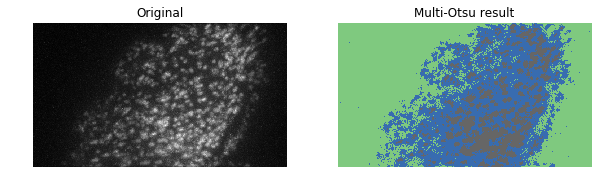

In [348]:
X_max = X[:200,:,:].max(axis=0)
thresholds = threshold_multiotsu(X_max)
regions = np.digitize(X_max, bins=thresholds)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(X_max, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from
# multi-Otsu.
#ax[1].hist(X_max.ravel(), bins=255)
#ax[1].set_title('Histogram')
#for thresh in thresholds:
#    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[1].imshow(regions, cmap='Accent')
ax[1].set_title('Multi-Otsu result')
ax[1].axis('off')

plt.savefig('multi_otsu.png')
plt.subplots_adjust()
plt.show()

In [349]:
X_max = X[:200,:,:].max(axis=0)
Y_max = Y[200:,:,:].max(axis=0)
X_max_signal = np.where(X_max > thresholds[1])
ymax_patch = []
X_feat = np.zeros((len(X_max_signal[0]), 32))

for i in range(len(X_max_signal[0])):
    i1 = X_max_signal[0][i]
    i2 = X_max_signal[1][i]
    ymax_patch.append(np.max(Y[200:,:,:][:,max(0,(i1-2)):(i1+3),:][:,:,(i2-2):(i2+3)]))
    features = []
    for window in [0, 100, 150, 180]:
        for patch_size in [0, 2, 5, 10]:
            fmax = np.max(X[window:200,:,:]
                   [:,max(0,(i1-patch_size)):(i1+patch_size+1),:]
                   [:,:,(i2-patch_size):(i2+patch_size+1)])
            fsum = np.sum((X[window:200,:,:]
                    [:,max(0,(i1-patch_size)):(i1+patch_size+1),:]
                    [:,:,(i2-patch_size):(i2+patch_size+1)] > thresholds[1]))
            features += [fmax, fsum]
    X_feat[i] = features       


In [357]:
ymax_order = np.argsort(ymax_patch)
Y_max_patch = np.array([[np.max(Y_max[max(0,(i1-2)):min((i1+3), len(Y_max)),:][:,max(0,(i2-2)):min((i2+3), len(Y_max[0]))])
                       for i1 in range(len(Y_max))]
                       for i2 in range(len(Y_max[0]))])
Y_max_patch = np.transpose(Y_max_patch)
thresholds = threshold_multiotsu(Y_max_patch)
ymax_label = (np.array(ymax_patch) > thresholds[1])

## make gifs for patches w/o events

In [172]:
for k in range(100):
    i = ymax_order[-k]
    i1 = X_max_signal[0][i]
    i2 = X_max_signal[1][i]
    kargs = {'duration': 5}
    clip = X[:200,:,:][:,max(0,(i1-10)):(i1+10),:][:,:,(i2-10):(i2+10)]
    clip = (clip - clip.min()) / (clip.max() - clip.min())
    clip = np.array([np.ones((200, clip.shape[1], clip.shape[2])), 1 - clip, 1 - clip])
    clip = clip.transpose((1, 2, 3, 0))
    clip = clip * 255
    #clip = np.repeat(np.expand_dims(clip, axis=3), 3, axis=3)
    fname = '/accounts/grad/xsli/abc-image-understanding/endocytosis_prediction/clips/class1_' + str(k) + '.gif'
    #imageio.mimsave(fname, clip, format='GIF', duration=0.04)
    array2gif.write_gif(clip, fname, fps=20)

## Random Forest

In [351]:
X_feat.shape

(15732, 32)

In [360]:
X_train, X_test, Y_train, Y_test = train_test_split(X_feat, ymax_label, test_size=0.33, random_state=42)

In [361]:
m = LogisticRegression()
m.fit(X_train, Y_train)

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [362]:
m.score(X_test, Y_test)

0.6271186440677966

In [363]:
sum(Y_test)/len(Y_test)

0.4851694915254237

In [364]:
m.coef_

array([[-4.08991218e-04, -4.50589170e-03, -2.86844863e-06,
         2.52583773e-03, -1.39960257e-04, -2.22530948e-04,
         4.80467203e-05,  4.96688880e-04, -1.77124799e-04,
        -1.41089759e-03, -4.72506525e-05, -3.59493049e-04,
        -8.25013211e-05,  1.21783872e-03,  1.99434169e-04,
        -1.68123401e-03,  3.08445221e-05,  6.18792588e-03,
         6.57620708e-05,  7.03891244e-04,  1.19800468e-04,
        -2.34258216e-03,  5.48286290e-05,  1.76029080e-03,
         8.63364639e-06, -2.94060599e-03,  1.89905697e-04,
         5.07707333e-03,  7.82717241e-05, -3.09806004e-04,
        -6.63384795e-05, -3.69131836e-04]])

In [382]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [383]:
clf.score(X_test, Y_test)

0.8936825885978429

In [377]:
Y_pred = clf.predict(X_test)

In [378]:
sum(Y_pred == Y_test)/len(Y_test)

0.8936825885978429

In [379]:
sum(Y_test)/len(Y_test)

0.4851694915254237

In [385]:
Y_score = clf.predict_log_proba(X_test)

/usr/local/linux/anaconda3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:631: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


In [391]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(Y_test, np.exp(Y_score[:, 1]))

In [392]:
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.9540641888575372


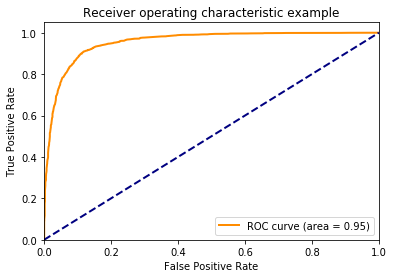

In [395]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('pixelpred_roc.png')
plt.show()